<a href="https://colab.research.google.com/github/KimaniKibuthu/Alzheimers-Disease-Classification/blob/main/Copy_of_Alzheimer's_Disease_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Alzheimer's Disease Classification

## Introduction
In this project we will try and accurately predict Alzheimer's from MRI scans.

## Methodology
The following procedures will be taken:
* Data Obtainance and preparation
* Modelling




# Libraries, Functions and Variables

In [33]:
# Import libraries
import os
import shutil
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import PIL
from PIL import Image

from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import tensorflow as tf
from tensorflow.keras.utils import Sequence
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.applications import InceptionV3

In [17]:
# Variables
train_path = '/content/Alzheimers/Alzheimer_s Dataset/train'
test_path = '/content/Alzheimers/Alzheimer_s Dataset/test'


TEST_SIZE = 0.5
SEED = 42
EPOCHS = 10
BATCH_SIZE = 64
IMG_SIZE = 299
LR = 0.0001

# Data Obtainance

In [12]:
# Setup to download data
from google.colab import files
files.upload()

Saving Alzheimer.zip to Alzheimer.zip


In [13]:
# Load the data
!unzip /content/Alzheimer.zip


Streaming output truncated to the last 5000 lines.
  inflating: Alzheimer's/Alzheimer_s Dataset/train/Demented/mildDem208.jpg  
  inflating: Alzheimer's/Alzheimer_s Dataset/train/Demented/mildDem209.jpg  
  inflating: Alzheimer's/Alzheimer_s Dataset/train/Demented/mildDem21.jpg  
  inflating: Alzheimer's/Alzheimer_s Dataset/train/Demented/mildDem210.jpg  
  inflating: Alzheimer's/Alzheimer_s Dataset/train/Demented/mildDem211.jpg  
  inflating: Alzheimer's/Alzheimer_s Dataset/train/Demented/mildDem212.jpg  
  inflating: Alzheimer's/Alzheimer_s Dataset/train/Demented/mildDem213.jpg  
  inflating: Alzheimer's/Alzheimer_s Dataset/train/Demented/mildDem214.jpg  
  inflating: Alzheimer's/Alzheimer_s Dataset/train/Demented/mildDem215.jpg  
  inflating: Alzheimer's/Alzheimer_s Dataset/train/Demented/mildDem216.jpg  
  inflating: Alzheimer's/Alzheimer_s Dataset/train/Demented/mildDem217.jpg  
  inflating: Alzheimer's/Alzheimer_s Dataset/train/Demented/mildDem218.jpg  
  inflating: Alzheimer's/A

# Data Preparation

**Format data to ease working on it**

In [18]:
def directory_creator(name_of_directory):
  """
  Creates a new directory and moves all images to this directory

  Args:
    name_of_directory: (str) The name of your directory

  """
  # Import the variable base path
  global test_path

  # Create new directory
  new_path = os.path.join(test_path, name_of_directory)
  if not os.path.exists(new_path):
     os.makedirs(new_path)
  
  # Move images to new directory
  directories = os.listdir(test_path)
  for directory in directories:
    if directory == 'Demented' or directory == 'NonDemented':
       directory_path = os.path.join(test_path, directory)
       files = os.listdir(directory_path)
       for index, file_name in enumerate(files):
           file_path = os.path.join(new_path, f'{index}-{directory}.jpg')
          #  if not os.path.exists(file_path):
          #    os.mkdir(file_path)
           shutil.copy(os.path.join(directory_path, file_name), file_path)

In [19]:
# Create a dataframe maker
def dataframe_creator(name_of_directory):
  """
  Updates the dataframe to a new dataframe with the present 
  images in new directory 

  Args:
    name_of_directory: (str) The name of your directory

  Returns:
    updated_df: (DataFrame): the updated dataframe

  """
  # Get the image filenames from the directory
  image_files = os.listdir(name_of_directory)

  # Get the labels from the coffee data 
  labels = []
  for image_file in image_files:
    label = image_file.split(sep='-')[1].split(sep='.')[0]
    labels.append(label)

  # Create new dataframe
  updated_df = pd.DataFrame({'files':image_files,
                             'labels':labels})
  
  return updated_df

In [20]:
# Create new directory
directory_creator('test_and_validation')

In [21]:
# Create new dataframe
hold_out_df = dataframe_creator('/content/Alzheimers/Alzheimer_s Dataset/test/test_and_validation')

**Check if data is corect**

In [22]:
# Define data checker
def data_checker(df, images_path):
  """
  Checks whether the values in the files column exist in the directory

  Args:
    df: (DataFrame) The data containing the files column
    images_path: (str) The path to the directory containing the images
  
  Prints:
    Whether the file is present or not

  """
  for file_name in df.files.values:
    if os.path.exists(os.path.join(images_path, file_name)):
      continue
    else:
      print(f'The file {file_name} cannot be found')

In [23]:
def image_checker(df, images_path):
  """
  Checks whether the images can be opened.

  Args:
    df: (DataFrame) The data containing the files column
    images_path: (str) The path to the directory containing the images
  
  Returns:
    data_final: (DataFrame) The data containing the files that can be opened

  """

  bad_list = []
  for filee in os.listdir(images_path):
          file_path = os.path.join(images_path, filee)
          print('** Path: {}  **'.format(file_path), end="\r", flush=True)
          try:
            im = Image.open(file_path)
          except (FileNotFoundError, PIL.UnidentifiedImageError):
            bad_list.append(file_path)
            continue
  
  if len(bad_list)!=0:
    file_name = bad_list[0].split(sep='-')[-1]
    data_final = df[df['files']!=file_name].reset_index(drop=True)
  
  else:
    data_final = df.copy()

  return data_final



In [24]:
def file_checker(df, images_path):
  """
  Checks whether file is good to go for modelling and exploration.

  Args:
    df: (DataFrame) The data containing the files column
    images_path: (str) The path to the directory containing the images
  
  Returns:
    data_final: (DataFrame) The data containing the files that can be opened
  """

  data_checker(df, images_path)
  data_final = image_checker(df, images_path)
  return data_final


In [25]:
# Check files
hold_out_df = file_checker(hold_out_df,
                           '/content/Alzheimers/Alzheimer_s Dataset/test/test_and_validation')

**Explore the data**

In [26]:
# View data
hold_out_df.head()

,files,labels
0,364-NonDemented.jpg,NonDemented
1,503-Demented.jpg,Demented
2,164-NonDemented.jpg,NonDemented
3,331-Demented.jpg,Demented
4,252-NonDemented.jpg,NonDemented


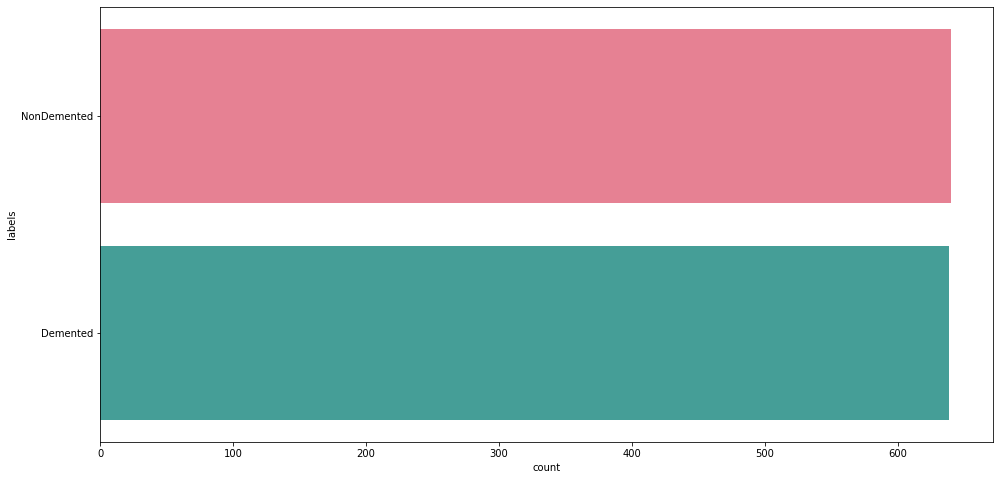

In [27]:
# View distribution of label in test

plt.figure(figsize=(16, 8))
sns.countplot(y='labels', data= hold_out_df, palette='husl');

In [28]:
# View percentage
hold_out_df['labels'].value_counts(normalize=True)*100

NonDemented    50.039093
Demented       49.960907
Name: labels, dtype: float64

The data is balanced. Use https://www.linkedin.com/pulse/some-tricks-handling-imbalanced-dataset-image-m-farhan-tandia/

**View images**

In [29]:
# function to view images
def show_images(df, the_path, class_name):
    """
    Prints out images

    Args:
      df: (DataFrame): DataFrame containing the image files
      the_path: (str) the path of the directory containing the images
      class_name: (str) the label that we want to visualize

    """
    # Get images 
    print(f'{class_name}')
    # Extract 16 random images from it
    temp_df = df.loc[df['labels']==class_name]
    random_images = [np.random.choice(temp_df['files'].values) for i in range(8)]

    # Adjust the size of your images
    plt.figure(figsize=(16,12))

    # Iterate and plot random images
  
    for i in range(8):
        plt.subplot(2,4,i+1)
        img = plt.imread(os.path.join(the_path, random_images[i]))
        plt.imshow(img, cmap='gray')
        plt.axis('off')

    # Adjust subplot parameters to give specified padding
    plt.tight_layout() 


MildDemented


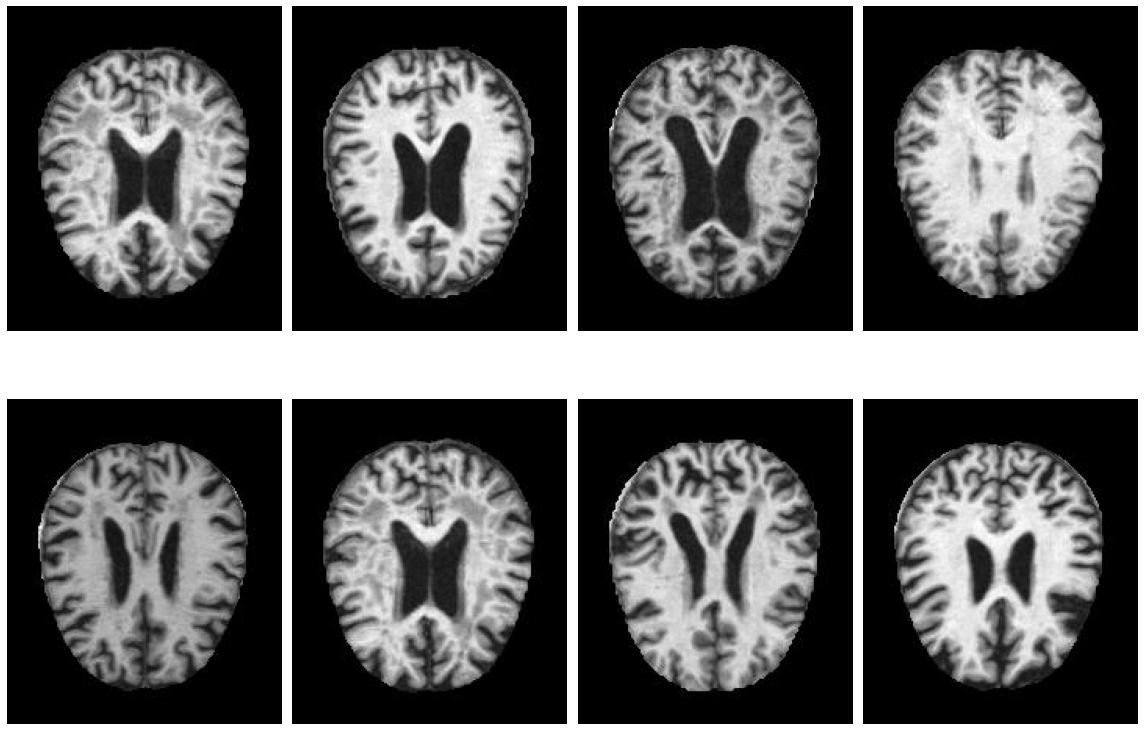

In [ ]:
# Show mild demented
show_images(hold_out_df,
            '/content/Alzheimer_s Dataset/test/test_and_validation',
            'MildDemented')

ModerateDemented


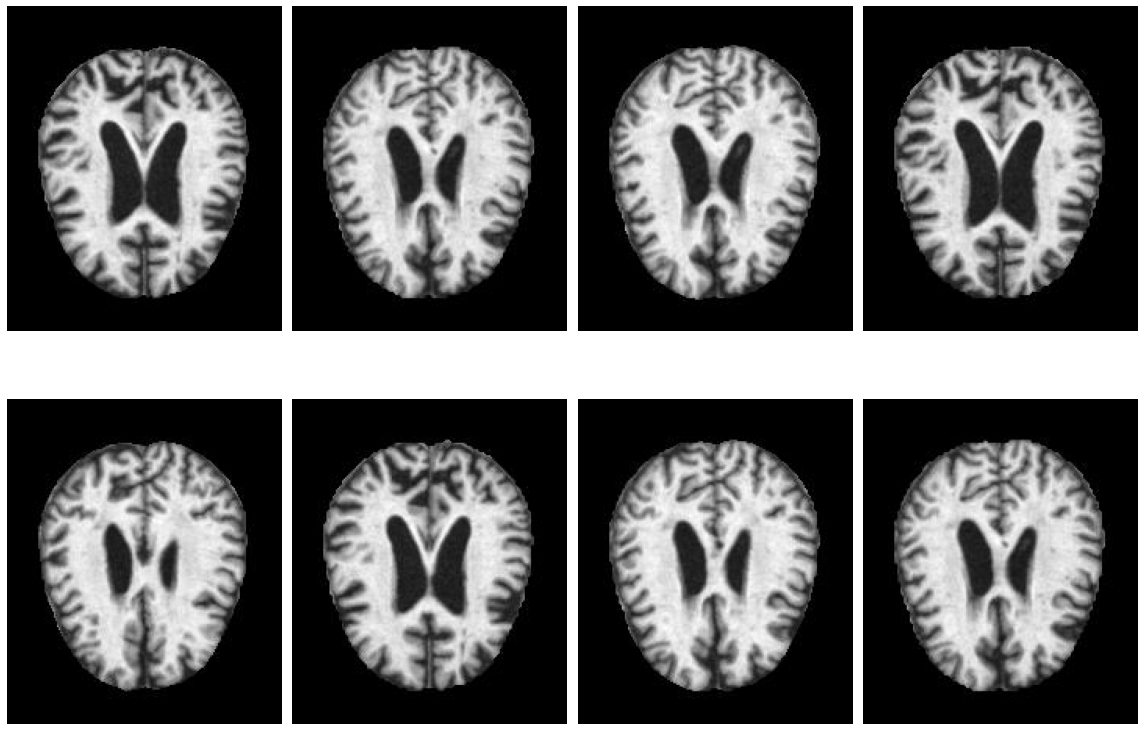

In [ ]:
# Moderate demented
show_images(hold_out_df,
            '/content/Alzheimer_s Dataset/test/test_and_validation',
            'ModerateDemented')

NonDemented


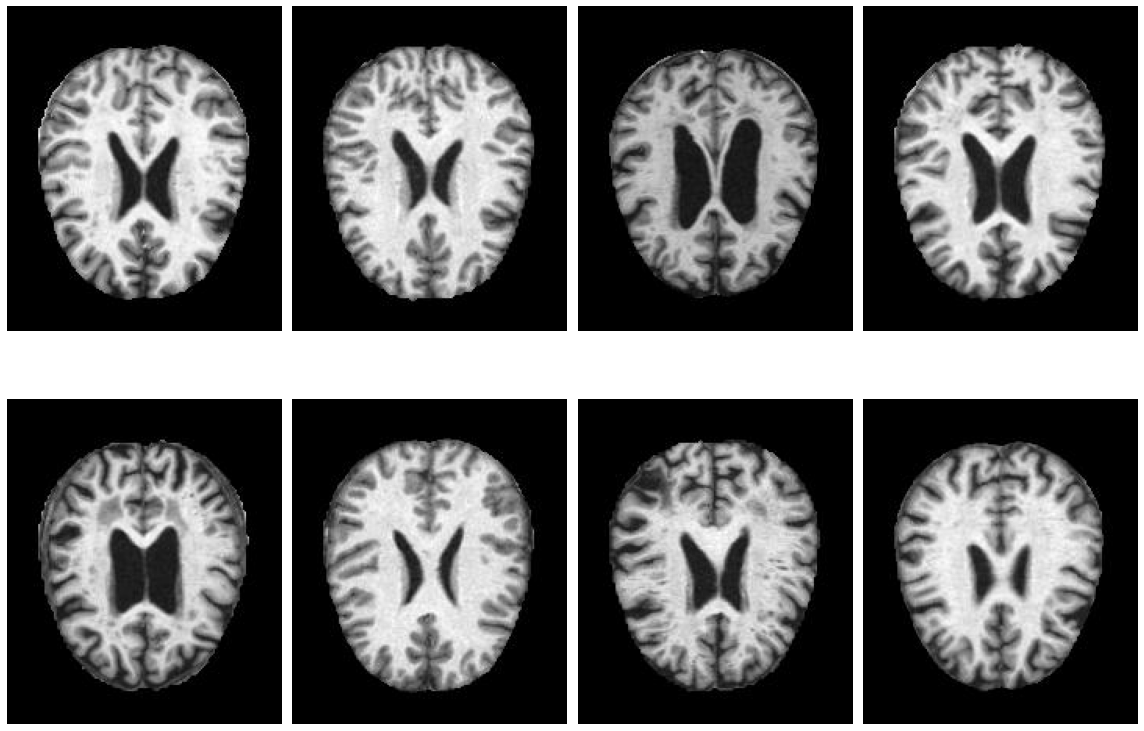

In [ ]:
# Non Demented
show_images(hold_out_df,
            '/content/Alzheimer_s Dataset/test/test_and_validation',
            'NonDemented')

VeryMildDemented


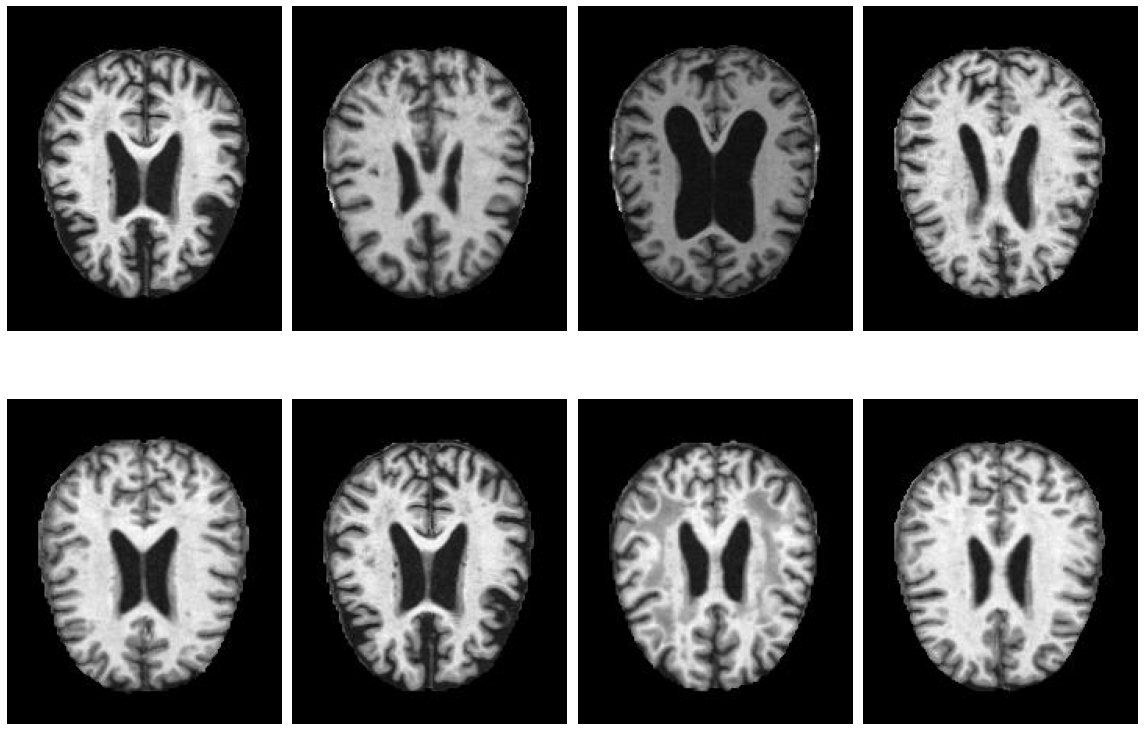

In [ ]:
# Very mild demented
show_images(hold_out_df,
            '/content/Alzheimer_s Dataset/test/test_and_validation',
            'VeryMildDemented')

**Split Data**


In [30]:
test_set, validation_set = train_test_split(hold_out_df, 
                                            random_state=SEED,
                                            test_size=TEST_SIZE,
                                            stratify=hold_out_df['labels']
                                            )

**ImageDataGenerator**

In [32]:
# Create generators
train_generator = ImageDataGenerator(
                                     width_shift_range=0.1,
                                     height_shift_range=0.1,
                                     shear_range=0.2,
                                     brightness_range=(1.0, 1.5),
                                     zoom_range= (1.0, 1.2),
                                     preprocessing_function=tf.keras.applications.inception_v3.preprocess_input)

val_generator = ImageDataGenerator(preprocessing_function=tf.keras.applications.inception_v3.preprocess_input)

test_generator  = ImageDataGenerator(preprocessing_function=tf.keras.applications.inception_v3.preprocess_input)

# Run them
train_flow = train_generator.flow_from_directory(
                                                 train_path,
                                                 target_size=(IMG_SIZE,IMG_SIZE),
                                                 batch_size=BATCH_SIZE,
                                                 class_mode='categorical'
                                                 )

val_flow = test_generator.flow_from_dataframe(validation_set,
                                             '/content/Alzheimers/Alzheimer_s Dataset/test/test_and_validation',
                                             x_col='files',
                                             y_col='labels',
                                             target_size=(IMG_SIZE,IMG_SIZE),
                                             batch_size=BATCH_SIZE,
                                             class_mode='categorical',
                                             shuffle=False
                                             )
test_flow = test_generator.flow_from_dataframe(test_set,
                                             '/content/Alzheimers/Alzheimer_s Dataset/test/test_and_validation',
                                             x_col='files',
                                             y_col='labels',
                                             target_size=(IMG_SIZE,IMG_SIZE),
                                             batch_size=BATCH_SIZE,
                                             class_mode='categorical',
                                             shuffle=False
                                             )


Found 5121 images belonging to 2 classes.
Found 640 validated image filenames belonging to 2 classes.
Found 639 validated image filenames belonging to 2 classes.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


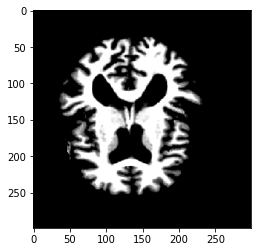

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


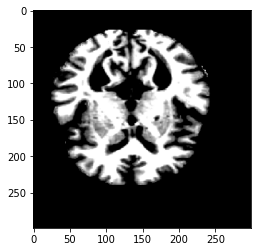

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


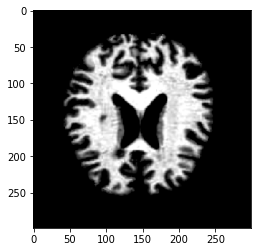

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


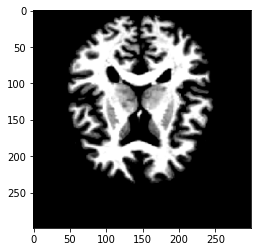

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


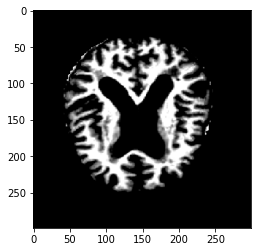

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


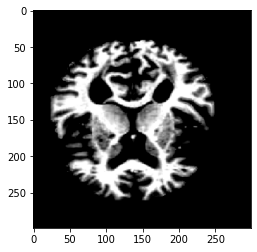

In [ ]:
# Visualize
x_batch, y_batch = next(train_flow)
for i in range (0,6):
    image = x_batch[i]
    plt.imshow(image)
    plt.show()

# Modelling

In [34]:
# Get Class Weights
class_weights = class_weight.compute_class_weight(
                                        class_weight = "balanced",
                                        classes = np.unique(val_flow.classes),
                                        y = val_flow.classes                                                    
                                    )
class_weights = dict(zip(np.unique(val_flow.classes), class_weights))
class_weights

{0: 1.0, 1: 1.0}

In [45]:
# Create model function
def create_model():
  
  # Build model
  inception =InceptionV3(include_top=False,
                          input_shape=(IMG_SIZE, IMG_SIZE, 3))
  
  for layer in inception.layers:
    layer.trainable = True

  model = Sequential([
  
                       inception,
                       GlobalAveragePooling2D(),
                      
                       Dense(512, activation = 'relu'),
                       Dropout(0.8),

                       Dense(256, activation = 'relu'),
                       Dropout(0.6),

                       Dense(1, activation = 'sigmoid')])

  adam = tf.keras.optimizers.Adam(LR)
  auc = tf.keras.metrics.AUC(name='auc')
  
  # Compile model
  model.compile(loss = 'binary_crossentropy',
                optimizer = adam,
                metrics = ['accuracy', auc])
  
  return model

In [46]:
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1 **(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(0.01, 20)

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)

In [47]:
# Create function to fit model
def model_fitter(model):

  # instantiate callbacks
  global lr_scheduler
  
  early_stopper = tf.keras.callbacks.EarlyStopping(monitor='val_auc',
                                                 patience=3)

  # reduce learning rate
  reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_auc',
                                  factor = 0.1,
                                  patience = 2,
                                  min_lr = 1e-6,
                                  mode = 'min',
                                  verbose = 1)
  
  checkpoint = tf.keras.callbacks.ModelCheckpoint('content/Best.h5',
                                                  monitor='val_loss',
                                                  mode = 'min' ,
                                                  verbose=1,
                                                  save_best_only=True,
                                                  save_weights_only=False)
  

  callbacks = [early_stopper, reduce_lr, checkpoint]

  # Train model
  history = model.fit(train_flow,
                    epochs=EPOCHS,
                    steps_per_epoch=len(train_flow),
                    validation_data=val_flow,
                    validation_steps=len(val_flow),
                    callbacks=callbacks
                    #class_weight=class_weights
                    )
  
  return history, model

In [48]:
 # create model
 model = create_model()

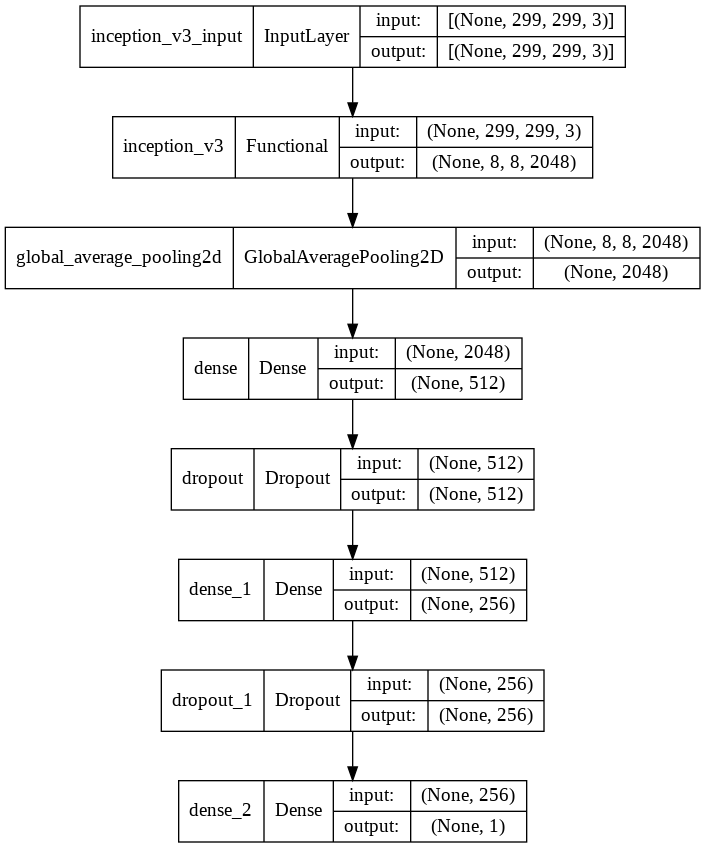

In [39]:
# View model
tf.keras.utils.plot_model(model, "model.png", show_shapes=True)

In [49]:
# Train model
history, model = model_fitter(model)

Epoch 1/10


InvalidArgumentError: ignored

In [ ]:
# Visualization function
def plot_interactive_figures(model_history, metric, all=True, test_data=True):
    """
    Plot the performance metrics of the model


    :param model_history: history

    The model history obtained from model.fit()

    :param metric: str
    The performance metric you want to use.**loss**, **auc**

    :param all: bool
    default=True. If true, overrides metric and plots figures of auc and loss.
    If false, plots the metric defined.

    :param test_data: bool
    default = True.
    If you have used validation data or not

    :return:
    Performance of the model
    """

    import plotly.graph_objects as go

    if all:
        if test_data:
            acc = model_history.history['auc']
            val_acc = model_history.history['val_auc']

            loss = model_history.history['loss']
            val_loss = model_history.history['val_loss']
            epochs = list(range(len(acc)+1))
            # Plots
            ax = go.Figure()
            ax.add_trace(go.Scatter(x=epochs, y=val_acc, name='Validation auc',
                                    line=dict(color='yellow', width=4)))
            ax.add_trace(go.Scatter(x=epochs, y=acc, name='Train auc',
                                    line=dict(color='blue', width=4)))
            ax.update_layout(title='Train and Validation auc plots',
                             xaxis_title='Epochs',
                             yaxis_title='auc')
            ax.show()

            bx = go.Figure()
            bx.add_trace(go.Scatter(x=epochs, y=val_loss, name='Validation Loss',
                                    line=dict(color='yellow', width=4)))
            bx.add_trace(go.Scatter(x=epochs, y=loss, name='Train Loss',
                                    line=dict(color='blue', width=4)))
            bx.update_layout(title='Train and Validation Loss plots',
                             xaxis_title='Epochs',
                             yaxis_title='Loss')
            bx.show()

        if not test_data:
            acc = model_history.history['auc']
            loss = model_history.history['loss']
            epochs = list(range(len(acc)+1))

            cx = go.Figure()
            cx.add_trace(go.Scatter(x=epochs, y=acc, name='auc',
                                    line=dict(color='blue', width=4)))
            cx.update_layout(title='auc plot',
                             xaxis_title='Epochs',
                             yaxis_title='auc')
            cx.show()

            dx = go.Figure()
            dx.add_trace(go.Scatter(x=epochs, y=loss, name='Loss',
                                    line=dict(color='yellow', width=4)))
            dx.update_layout(title='Loss plot',
                             xaxis_title='Epochs',
                             yaxis_title='Loss')
            dx.show()

    if not all:
        if test_data:
            value_train = model_history.history[metric]
            value_test = model_history.history['val_{}'.format(metric)]
            epochs = list(range(len(value_train)+1))

            ex = go.Figure()
            ex.add_trace(go.Scatter(x=epochs, y=value_test, name='Validation {}'.format(metric),
                                    line=dict(color='yellow', width=4)))
            ex.add_trace(go.Scatter(x=epochs, y=value_train, name='Train {}'.format(metric),
                                    line=dict(color='blue', width=4)))
            ex.update_layout(title='Train and Validation {} plots'.format(metric),
                             xaxis_title='Epochs',
                             yaxis_title='{}'.format(metric))
            ex.show()

        if not test_data:
            value_train = model_history.history[metric]
            epochs = list(range(len(value_train)+1))

            fx = go.Figure()
            fx.add_trace(go.Scatter(x=epochs, y=value_train, name='Train {}'.format(metric),
                                    line=dict(color='blue', width=4)))
            fx.update_layout(title='Train {} plots'.format(metric),
                             xaxis_title='Epochs',
                             yaxis_title='{}'.format(metric))
            fx.show()

In [ ]:
plot_interactive_figures(history, 'auc')

## Validate model
Use the validation data to validate the results obtained on the train set.

In [ ]:
def model_validator(data_generator, data):

  # Get loss, binary accuracy and AUC
  history_list = model.evaluate(data_generator, verbose=False)

  # Get the classification report

  # Get predictions (1, 0)
  predictions = (np.argmax(model.predict(val_flow), axis=1))
  
  # Get label encode y_val
  mapping = data_generator.class_indices
  val_test = data.copy()
  val_test['labels'] = val_test['labels'].replace(mapping)
  y_val = val_test['labels'].values

  # print out reports
  print(f'The loss is {history_list[0]}, the categorical accuracy is {history_list[1]} & the AUC is {history_list[2]}')
  print(' ')
  print(classification_report(y_val, predictions))


In [ ]:
# View the report
model_validator(val_flow, validation_set)

The loss is 1.025892972946167, the categorical accuracy is 0.518750011920929 & the AUC is 0.8086791038513184
 
              precision    recall  f1-score   support

           0       0.30      0.63      0.41        90
           1       0.19      1.00      0.32         6
           2       0.72      0.64      0.68       320
           3       0.48      0.28      0.36       224

    accuracy                           0.52       640
   macro avg       0.42      0.64      0.44       640
weighted avg       0.57      0.52      0.52       640



## Evaluate using test set

In [ ]:
# Evaluate with test set
model_validator(test_flow)